In [94]:
import findspark
findspark.init('/home/hdoop/Downloads/spark')

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import isnan, when, count, col, log1p, expm1, instr, lit, udf, array, explode, sum, avg, max, min, mean, stddev, countDistinct, desc, asc, monotonically_increasing_id
from pyspark.sql import DataFrame

In [96]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

In [97]:
spark = SparkSession.builder.appName('RecommendationModel').config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.5.0').getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions","5")

### Read Data ###

In [98]:
schema= StructType([
    # StructField("_id", StringType(), True),
    StructField("track_id", IntegerType(), True),
    StructField("track_title", StringType(), True),
    StructField("track_genre_top", StringType(), True),
    StructField("track_listens", IntegerType(), True),
    StructField("track_favorites", IntegerType(), True),
    StructField("album_title", StringType(), True),
    StructField("album_listens", IntegerType(), True),
    StructField("artist_name", StringType(), True),
    StructField("mfcc_features", ArrayType(FloatType()), True)
])


In [99]:
sc= spark.sparkContext
# connecting to MongoDB
client= MongoClient('mongodb://localhost:27017')
mongo_database= client['MusicModel']
collection_name= mongo_database['audio_features']
read_data= collection_name.find()
tracks_rdd= sc.parallelize(list(read_data))

In [100]:
audio_df= spark.createDataFrame(tracks_rdd, schema)

In [101]:
audio_df.printSchema()

root
 |-- track_id: integer (nullable = true)
 |-- track_title: string (nullable = true)
 |-- track_genre_top: string (nullable = true)
 |-- track_listens: integer (nullable = true)
 |-- track_favorites: integer (nullable = true)
 |-- album_title: string (nullable = true)
 |-- album_listens: integer (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- mfcc_features: array (nullable = true)
 |    |-- element: float (containsNull = true)



### Data Cleaning(EDA and Processing) ###

In [102]:
# filtering those tracks which have more than 10 listens and less than 1000 listens
filtered_tracks= audio_df.filter((audio_df['track_listens'] >= 10) & (audio_df['track_listens'] <= 1000))

In [103]:
spark.conf.set("spark.mongodb.input.batchSize.perDocument", 100)

In [104]:
filtered_tracks_df= filtered_tracks.sample(withReplacement= False, fraction= 0.01, seed= 40).toPandas()

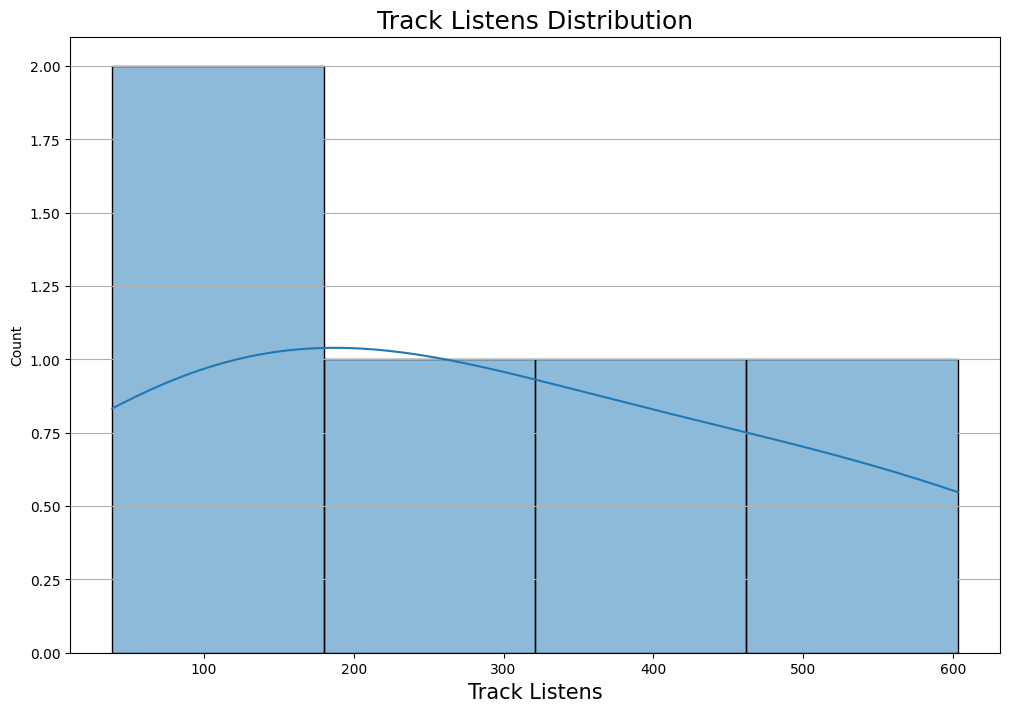

In [105]:
# plotting the distribution of track listens
plt.figure(figsize= (12, 8))
sns.histplot(data= filtered_tracks_df, x= "track_listens", kde= True)
plt.grid(which= 'major', axis= 'y')
plt.xlabel('Track Listens', size= 15)
plt.title('Track Listens Distribution', size= 18)
plt.show()

In [106]:
# checking for null values
filtered_tracks.dropna()

DataFrame[track_id: int, track_title: string, track_genre_top: string, track_listens: int, track_favorites: int, album_title: string, album_listens: int, artist_name: string, mfcc_features: array<float>]

In [107]:
# we can further clean our data to filter out repeating artists
filtered_tracks.createOrReplaceTempView('artist_name')
distinct_artists= spark.sql("SELECT * FROM artist_name WHERE artist_name LIKE 'Area%'")

In [108]:
distinct_artists.show()

+--------+-----------+---------------+-------------+---------------+--------------------+-------------+-----------+--------------------+
|track_id|track_title|track_genre_top|track_listens|track_favorites|         album_title|album_listens|artist_name|       mfcc_features|
+--------+-----------+---------------+-------------+---------------+--------------------+-------------+-----------+--------------------+
|     156|   Track 01|   Experimental|          362|              2|Thee Haunted Cobb...|         1845|     Area C|[-321.75662, 164....|
|     157|   Track 02|   Experimental|          190|              1|Thee Haunted Cobb...|         1845|     Area C|[-302.882, 152.49...|
|     158|   Track 03|   Experimental|          163|              1|Thee Haunted Cobb...|         1845|     Area C|[-323.18433, 150....|
|     159|   Track 04|   Experimental|          130|              1|Thee Haunted Cobb...|         1845|     Area C|[-335.6162, 159.1...|
|     160|   Track 05|   Experimental|   

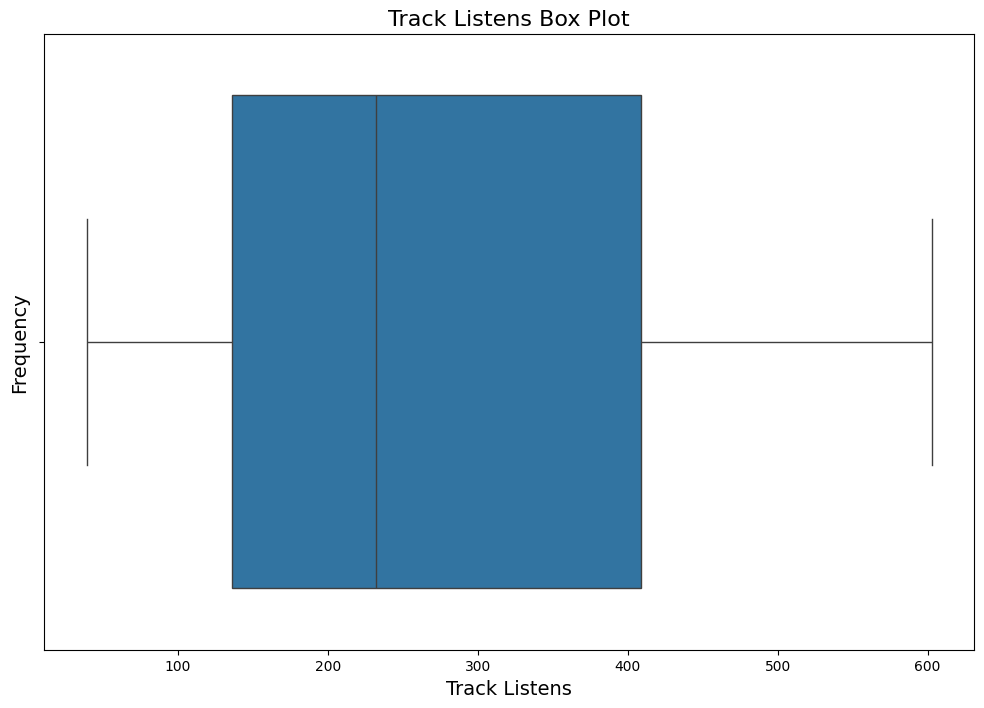

In [109]:
# plotting a box plot to show the skewness of track listens
plt.figure(figsize= (12, 8))
sns.boxplot(x= filtered_tracks_df['track_listens'])
plt.title('Track Listens Box Plot', size= 16)
plt.xlabel('Track Listens', size= 14)
plt.ylabel('Frequency', size= 14)
plt.show()

Since the data is right skewed, we will use log transformation on our target variable.

In [110]:
filtered_tracks= filtered_tracks.withColumn('transformed_listens', log1p('track_listens'))

In [111]:
filtered_tracks_df= filtered_tracks.sample(withReplacement= False, fraction= 0.01, seed= 40).toPandas()

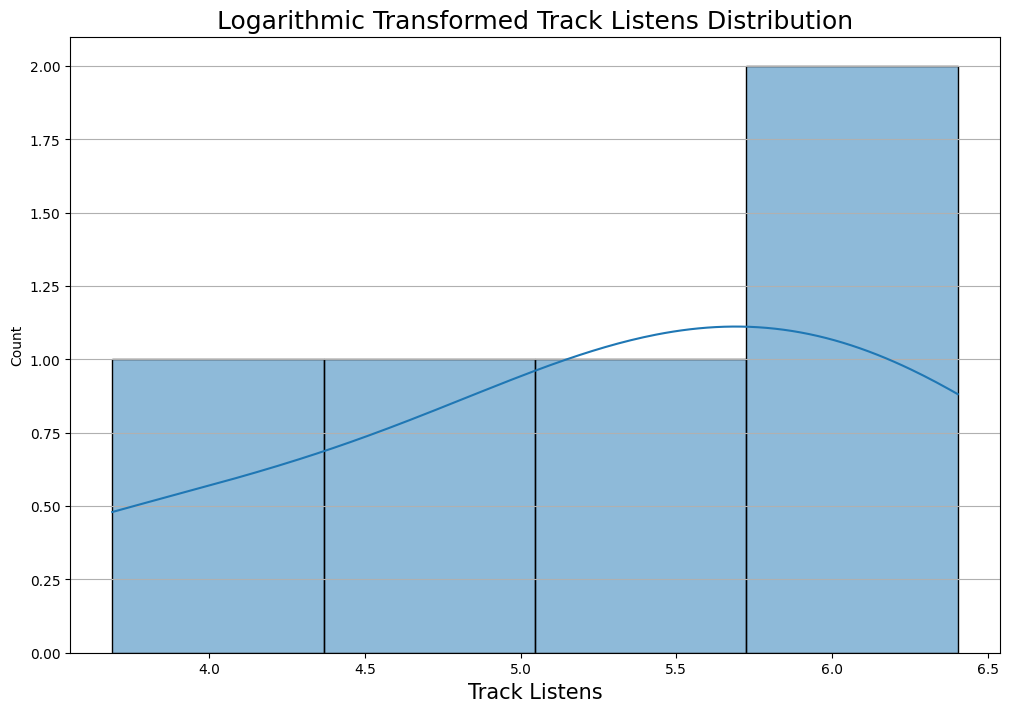

In [112]:
# plotting the distribution of transformed track listens
plt.figure(figsize= (12, 8))
sns.histplot(data= filtered_tracks_df, x= 'transformed_listens', kde= True)
plt.grid(which= 'major', axis= 'y')
plt.xlabel('Track Listens', size= 15)
plt.title('Logarithmic Transformed Track Listens Distribution', size= 18)
plt.show()

In [113]:
# using StringIndexer for both columns
title_indexer= StringIndexer(inputCol= "track_title", outputCol= "encoded_track_title")
genre_indexer= StringIndexer(inputCol= "track_genre_top", outputCol= "encoded_top_genre")
filtered_tracks= title_indexer.fit(filtered_tracks).transform(filtered_tracks)
filtered_tracks= genre_indexer.fit(filtered_tracks).transform(filtered_tracks)

Now that we have tried to lower the bias as much as we could by cleaning the data and transforming it, we can move to model training.

### Model Training and Testing ###

In [143]:
# not needed for unsupervised models
# train_data, test_data= filtered_tracks.randomSplit([0.8, 0.2], seed= 40) # 80-20 split for training and testing data

In [151]:
feature_columns= ["track_id", "encoded_track_title", "encoded_top_genre"]
target_column= "transformed_listens"
filtered_df= filtered_tracks.select(*feature_columns, target_column)

In [152]:
filtered_df.show(5)

+--------+-------------------+-----------------+-------------------+
|track_id|encoded_track_title|encoded_top_genre|transformed_listens|
+--------+-------------------+-----------------+-------------------+
|       3|              160.0|              4.0|  6.244166900663736|
|     134|              396.0|              4.0|    6.8501261661455|
|     138|              360.0|              1.0|  6.194405391104672|
|     139|              106.0|              3.0|  6.368187186350492|
|     141|              301.0|              3.0|  6.587550014824796|
+--------+-------------------+-----------------+-------------------+
only showing top 5 rows



In [154]:
# features will be transformed into a single column
assembler= VectorAssembler(inputCols= feature_columns, outputCol= "label")
# initialize the KMeans model
k_means= KMeans(featuresCol= "label", k= 5, seed= 40)
pipeline= Pipeline(stages= [assembler, k_means])
# fit the model
fit_model= pipeline.fit(filtered_df)
predictions= fit_model.transform(filtered_df)
# this function uses the predictions of the model to recommend tracks similar to the input track IDs
def recommend_tracks(input_id, output_file):
    with open(output_file, 'w') as f:
        for track_id in input_id:
            track_cluster= predictions.filter(col("track_id") == track_id).select("prediction").first()[0]
            recommended_tracks= predictions.filter(col("prediction") == track_cluster).select("track_id").limit(5).rdd.flatMap(lambda x: x).collect()
            f.write(f"Recommended Tracks for Track ID {track_id}:\n")
            for rec_track_id in recommended_tracks:
                f.write(f"{rec_track_id}\n")

example_track_id= filtered_df.select("track_id").limit(20).rdd.flatMap(lambda x: x).collect()
recommend_tracks(example_track_id, "recommended_tracks.txt")


In [155]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol= "label", predictionCol="prediction")

# Compute silhouette score
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")


Silhouette Score: 0.5936801537628262


In [161]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

assembler = VectorAssembler(
    inputCols=["encoded_track_title", "encoded_top_genre", "transformed_listens"],  
    outputCol="features"
)

# Initialize KMeans
k_means= KMeans(seed= 95)

pipeline= Pipeline(stages=[assembler, k_means])

# build parameter grid 
paramGrid= ParamGridBuilder() \
    .addGrid(k_means.k, [3, 5, 10]) \
    .addGrid(k_means.maxIter, [20, 50, 100]) \
    .build()

evaluator= ClusteringEvaluator()
# cross-validator
crossval= CrossValidator(
    estimator= pipeline,
    estimatorParamMaps= paramGrid,
    evaluator= evaluator,
    numFolds= 10
)

cvModel= crossval.fit(filtered_df) 

bestModel= cvModel.bestModel
bestK = bestModel.stages[-1].getK()  # Get the optimal number of clusters
print(f"Best number of clusters: {bestK}")


Best number of clusters: 3


In [93]:
spark.stop()